In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import time
import glob
import joblib
import pickle
import random
import warnings
import tensorflow as tf
from PIL import Image
from joblib import dump, load
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.utils import shuffle
from skimage.color import rgb2gray

print("Number of GPUs Available for TensorFlow: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPUs Available for TensorFlow:  1


In [3]:
# Function to filter out images smaller than a specified width and height
def filter_small_images(image_paths, min_width=32, min_height=32):
    """Filter out images smaller than the specified min_width and min_height."""
    filtered_paths = []
    for path in image_paths:
        with Image.open(path) as img:
            width, height = img.size
            if width >= min_width and height >= min_height:
                filtered_paths.append(path)
    return filtered_paths

# Function to retrieve images from a directory
def get_images_from_directory(directory, extensions):
    """Retrieve images with specified extensions from a directory."""
    images = []
    for ext in extensions:
        images.extend(glob.glob(f'{directory}/*.{ext}'))
    return images

# Specify common image extensions
extensions = ['png', 'jpg']

# Specify the categories of images
categories = [
    'ambulance', 'bus', 'car', 'crosswalk', 'cyclist', 'dont-care', 'fire-hydrant',
    'green-forward-traffic-light', 'green-advance-left-traffic-light', 'green-traffic-light',
    'misc', 'motorcycle', 'no-object', 'pedestrian', 'person', 'red-advance-left-traffic-light',
    'red-traffic-light', 'scooter', 'stop-sign', 'traffic-cone', 'tram', 'truck', 'van',
    'yellow-traffic-light', 'yellow-advance-left-traffic-light'
]

image_data = {}

# Load images from directories into arrays
for category in categories:
    images = filter_small_images(get_images_from_directory(f'..\\datasets\\classification-full\\cropped-images\\{category}', extensions))
    image_data[category] = images
    print(f'Images with {category.replace("-", " ")}: {len(images)}')

Images with ambulance: 248
Images with bus: 359
Images with car: 29236
Images with crosswalk: 131
Images with cyclist: 1671
Images with dont care: 7079
Images with fire hydrant: 103
Images with green forward traffic light: 78
Images with green advance left traffic light: 249
Images with green traffic light: 2674
Images with misc: 639
Images with motorcycle: 273
Images with no object: 17961
Images with pedestrian: 7311
Images with person: 666
Images with red advance left traffic light: 110
Images with red traffic light: 2729
Images with scooter: 90
Images with stop sign: 54
Images with traffic cone: 87
Images with tram: 687
Images with truck: 1396
Images with van: 2560
Images with yellow traffic light: 102
Images with yellow advance left traffic light: 33


In [4]:
X_hog_images = []
y_labels = []

for i, category in enumerate(categories):
    for path in image_data[category]:
        image_colour = mpimg.imread(path)
        image_colour = cv2.resize(image_colour, (64, 64))  # Resize image to 64x64
        image_grey = cv2.cvtColor(image_colour, cv2.COLOR_BGR2GRAY)
        hog_feature, hog_img = hog(image_colour[:,:,0], 
                                   orientations=11,
                                   pixels_per_cell=(16, 16), 
                                   cells_per_block=(2, 2),  
                                   transform_sqrt=False,
                                   visualize=True, 
                                   feature_vector=False)
        X_hog_images.append(hog_img)
        y_labels.append(i)

X_hog_images = np.array(X_hog_images)
X_hog_images = X_hog_images.reshape(X_hog_images.shape[0], 64, 64, 1)  # Reshape for CNN input
y_labels = np.array(y_labels)

print(f'HOG images shape: {X_hog_images.shape}')
print(f'HOG Labels shape: {y_labels.shape}')

HOG images shape: (76526, 64, 64, 1)
Labels shape: (76526,)


In [7]:
X = X_hog_images
y = y_labels
# with open("output.txt", "w") as file:
#     for i in y:
#         file.write(str(i) + "\n")

#y = tf.keras.utils.to_categorical(y, 10)

X, y = shuffle(X, y)

# with open("output2.txt", "w") as file:
#     for i in y:
#         file.write(str(i) + "\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# Data Preparation
# Shuffle the dataset
#X_train, y_train = shuffle(X_train, y_train)
#X_test, y_test = shuffle(X_test, y_test)

print(f'Train features shape: {X_train.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Test features shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

# # Convert the images to grayscale
X_train_gray = np.sum(X_train/3, axis = 3, keepdims = True)
X_test_gray = np.sum(X_test/3, axis = 3, keepdims = True)

# # Normalize the images
X_train_gray_normalized = (X_train_gray - 128)/128
X_test_gray_normalized = (X_test_gray - 128)/128

#print(X_train_gray_normalized.shape)
#print(X_test_gray_normalized.shape)

Train features shape: (57394, 64, 64, 1)
Train labels shape: (57394,)
Test features shape: (19132, 64, 64, 1)
Test labels shape: (19132,)


class: truck
class: van
class: red-traffic-light
class: green-traffic-light
class: red-traffic-light
class: car
class: no-object
class: no-object
class: car
class: no-object
class: green-traffic-light
class: van
class: dont-care
class: car
class: car
class: no-object
class: no-object
class: no-object
class: pedestrian
class: no-object
class: car
class: van
class: van
class: no-object
class: pedestrian


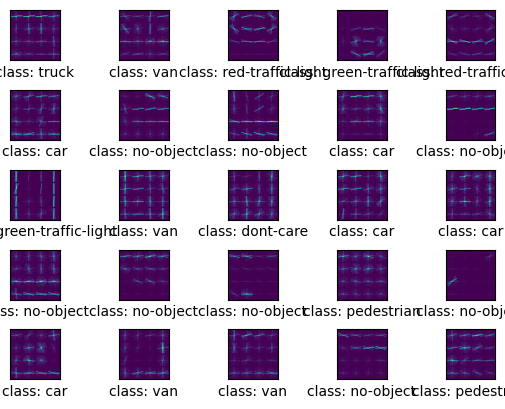

In [8]:
fig, axes = plt.subplots(5, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.8)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])

    xlabel = "class: {0}".format(categories[int(y_train[i])])
    print(xlabel)

    # Show the classes as the label on the x-axis
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])

In [9]:
image_shape = X_train[i].shape

l2_reg = 0.001

vgg16_model = Sequential([
        Input(shape = image_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_reg)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        Flatten(),
        Dense(4096, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(0.5),
        Dense(4096, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(0.5),
        Dense(25, activation='sigmoid') # 25 classes in the dataset
    ])

# specify the path to save the model
checkpoints_filepath = "..\\saved-models\\best_vgg16_model.hdf5"

# initialize the ModelCheckpoint callback
checkpoints = ModelCheckpoint(checkpoints_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

vgg16_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

model_training_time_label = 'VGG16 object classification training time: '

# Record the time it takes to train the model
start_time = time.time()

early_stopper = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 10, verbose = 1, mode = 'auto', restore_best_weights=True)

history = vgg16_model.fit(X_train, y_train, 
                        batch_size = 64, 
                        epochs = 200, 
                        verbose = 1, 
                        validation_split = (0.1),
                        callbacks = [checkpoints, early_stopper])

end_time = time.time()

training_time = end_time - start_time

# Output the training time into the file
with open('..\\model-comparison-metrics', 'a') as f:
    f.write(f'{model_training_time_label}{training_time}\\n')

print("Training time: {0}".format(training_time))

# Output model summary
vgg16_model.summary()

# Ouput test accuracy
score = vgg16_model.evaluate(X_test, y_test, verbose = 0)
print('Test Accuracy: {}'.format(score[1]))



# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

# opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0001, decay = 1e-6)

# model = createModel(X_train.shape[1:])

# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.summary()

Epoch 1/200
808/808 [==============================] - ETA: 0s - loss: 3.0379 - accuracy: 0.3798
Epoch 1: val_loss improved from inf to 2.11584, saving model to ..\saved-models\best_vgg16_model.hdf5
808/808 [==============================] - 1281s 1s/step - loss: 3.0379 - accuracy: 0.3798 - val_loss: 2.1158 - val_accuracy: 0.3819
Epoch 2/200
461/808 [================>.............] - ETA: 7:20 - loss: 2.0612 - accuracy: 0.3808

In [ ]:
%matplotlib inline
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model_prediction_time_label = 'CNN object classification prediction time: '

# Record the prediction time
start_time = time.time()

# Get the predictions for the test data
y_predicted = vgg16_model.predict(X_test)

# Use this for Multi-class classification
y_predicted_classes = np.argmax(y_predicted, axis=1)

# Use this for Multi-class classification
# y_predict_classes = np.argmax(y_predict, axis=1) # Try removing argmax and see what happens

# Use this for Binary classification
#predicted_classes = cnn_model.predict(X_test_gray_normalized)

# Get the indices to be plotted
y_true = y_test
correct = np.nonzero(y_predicted_classes == y_true)
incorrect = np.nonzero(y_predicted_classes != y_true)

# Mark the end time for prediction
end_time = time.time()

# Calculate prediction time
prediction_time = end_time - start_time

# Output the prediction time into the file
with open('model-comparison-metrics', 'a') as f:
    f.write(f'{model_prediction_time_label}{prediction_time}\\n')

print("Prediction time: {0}".format(prediction_time))

In [ ]:
cm = confusion_matrix(y_test, y_predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, y_predicted_classes))

In [ ]:
scores = vgg16_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
for x in range(10):
    test_image = X_test[x,:]
    predicted_cat = vgg16_model.predict(np.array([test_image])) # argmax returns the index of the max value
    label = y_test[x].argmax()
    if (predicted_cat != label):
        plt.title(f"Predicted: {class_names[predicted_cat]}, Label: {class_names[label]}")
        plt.imshow(test_image)
        plt.show()

In [ ]:
model_path = '..\\saved-models\\object-classification-vgg16.pkl'  # replace with the path to your model
dump(vgg16_model, model_path) # Save the model
#model = load(model_path)

In [ ]:
video_path = 'TestSets/Videos/1.mp4'
video_path_out = '{}_out.mp4'.format(video_path)

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame.shape[1], frame.shape[0]))


while ret:

    results = vgg16_model(frame)[0]
    threshold = 0.3
    for result in results.boxes.data.tolist():
        print(len(result))
        x1, y1, x2, y2, score, class_id = result

        if score > threshold:
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
            cv2.putText(frame, results.names[int(class_id)].upper()+(str(score)), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

    out.write(frame)
    ret, frame = cap.read()

cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
def filter_small_images(image_paths, min_width=32, min_height=32):
    """Filter out images smaller than the specified min_width and min_height."""
    filtered_paths = []
    for path in image_paths:
        with Image.open(path) as img:
            width, height = img.size
            if width >= min_width and height >= min_height:
                filtered_paths.append(path)
    return filtered_paths

def get_images_from_directory(directory, extensions):
    """Retrieve images with specified extensions from a directory."""
    images = []
    for ext in extensions:
        images.extend(glob.glob(f'{directory}/*.{ext}'))
    return images

# Specify common image extensions
extensions = ['png', 'jpg']

categories = [
    'ambulance', 'bus', 'car', 'crosswalk', 'cyclist', 'dont-care', 'fire-hydrant',
    'green-forward-traffic-light', 'green-advance-left-traffic-light', 'green-traffic-light',
    'misc', 'motorcycle', 'no-object', 'pedestrian', 'person_sitting', 'red-advance-left-traffic-light',
    'red-traffic-light', 'scooter', 'stop-sign', 'traffic-cone', 'tram', 'truck', 'van',
    'yellow-traffic-light', 'yellow-advance-left-traffic-light'
]

image_data = {}

for category in categories:
    images = filter_small_images(get_images_from_directory(f'..\\datasets\\classification-full\\cropped-images\\{category}', extensions))
    image_data[category] = images
    print(f'Images with {category.replace("-", " ")}: {len(images)}')

CODE ENDS HERE

In [ ]:
car_hog_accum = []

for i in car:
    image_colour = mpimg.imread(i)
    image_grey = cv2.cvtColor(image_colour, cv2.COLOR_BGR2GRAY)
    car_hog_feature, car_hog_img = hog(image_colour[:,:,0], 
                                    orientations=11,
                                    pixels_per_cell=(16, 16), 
                                    cells_per_block=(2, 2),  
                                    transform_sqrt=False,
                                    visualize=True, 
                                    feature_vector=True) #True
    
    car_hog_accum.append(car_hog_feature)

X_car = np.vstack(car_hog_accum).astype(np.float64)
y_car = np.ones(len(X_car))

print(X_car.shape)
print(y_car.shape)
print(y_car)

(8792, 396)
(8792,)
[1. 1. 1. ... 1. 1. 1.]


In [ ]:
no_object_hog_accum = []

for i in no_object:
    image_colour = mpimg.imread(i)
    image_grey = cv2.cvtColor(image_colour, cv2.COLOR_BGR2GRAY)
    no_object_hog_feature, no_object_hog_img = hog(image_colour[:,:,0], 
                                    orientations=11,
                                    pixels_per_cell=(16, 16), 
                                    cells_per_block=(2, 2),  
                                    transform_sqrt=False,
                                    visualize=True, 
                                    feature_vector=True) #True
    
    no_object_hog_accum.append(no_object_hog_feature)

X_no_object = np.vstack(no_object_hog_accum).astype(np.float64)
y_no_object = np.zeros(len(X_no_object))

print(X_no_object.shape)
print(y_no_object.shape)
print(y_no_object)

(8968, 396)
(8968,)
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
cyclist_hog_accum = []

for i in cyclist:
    image_colour = mpimg.imread(i)
    image_colour = cv2.resize(image_colour, (64, 64))  # Resize image to 64x64
    image_grey = cv2.cvtColor(image_colour, cv2.COLOR_BGR2GRAY)
    
    cyclist_hog_feature, cyclist_hog_img = hog(image_colour[:,:,0], 
                                    orientations=11,
                                    pixels_per_cell=(16, 16), 
                                    cells_per_block=(2, 2),  
                                    transform_sqrt=False,
                                    visualize=True, 
                                    feature_vector=True) #True
    
    cyclist_hog_accum.append(cyclist_hog_feature)

X_cyclist = np.vstack(cyclist_hog_accum).astype(np.float64)
y_cyclist = np.full(len(X_cyclist), 2)

print(X_cyclist.shape)
print(y_cyclist.shape)
print(y_cyclist)

(1593, 396)
(1593,)
[2 2 2 ... 2 2 2]


In [ ]:
pedestrian_hog_accum = []

for i in pedestrian:
    image_colour = mpimg.imread(i)
    image_colour = cv2.resize(image_colour, (64, 64))  # Resize image to 64x64
    image_grey = cv2.cvtColor(image_colour, cv2.COLOR_BGR2GRAY)
    pedestrian_hog_feature, pedestrian_hog_img = hog(image_colour[:,:,0], 
                                    orientations=11,
                                    pixels_per_cell=(16, 16), 
                                    cells_per_block=(2, 2),  
                                    transform_sqrt=False,
                                    visualize=True, 
                                    feature_vector=True) #True
    
    pedestrian_hog_accum.append(pedestrian_hog_feature)

X_pedestrian = np.vstack(pedestrian_hog_accum).astype(np.float64)
y_pedestrian = np.full(len(X_pedestrian), 3)

print(X_pedestrian.shape)
print(y_pedestrian.shape)
print(y_pedestrian)

(7311, 396)
(7311,)
[3 3 3 ... 3 3 3]


In [ ]:
tram_hog_accum = []

for i in tram:
    image_colour = mpimg.imread(i)
    image_colour = cv2.resize(image_colour, (64, 64))  # Resize image to 64x64
    image_grey = cv2.cvtColor(image_colour, cv2.COLOR_BGR2GRAY)
    tram_hog_feature, tram_hog_img = hog(image_colour[:,:,0], 
                                    orientations=11,
                                    pixels_per_cell=(16, 16), 
                                    cells_per_block=(2, 2),  
                                    transform_sqrt=False,
                                    visualize=True, 
                                    feature_vector=True) #True
    
    tram_hog_accum.append(tram_hog_feature)

X_tram = np.vstack(tram_hog_accum).astype(np.float64)
y_tram = np.full(len(X_tram), 4)

print(X_tram.shape)
print(y_tram.shape)
print(y_tram)

(570, 396)
(570,)
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 

In [ ]:
truck_hog_accum = []

for i in truck:
    image_colour = mpimg.imread(i)
    image_grey = cv2.cvtColor(image_colour, cv2.COLOR_BGR2GRAY)
    image_colour = cv2.resize(image_colour, (64, 64))  # Resize image to 64x64
    truck_hog_feature, truck_hog_img = hog(image_colour[:,:,0], 
                                    orientations=11,
                                    pixels_per_cell=(16, 16), 
                                    cells_per_block=(2, 2),  
                                    transform_sqrt=False,
                                    visualize=True, 
                                    feature_vector=True) #True
    
    truck_hog_accum.append(truck_hog_feature)

X_truck = np.vstack(truck_hog_accum).astype(np.float64)
y_truck = np.full(len(X_truck), 5)

print(X_truck.shape)
print(y_truck.shape)
print(y_truck)

(1127, 396)
(1127,)
[5 5 5 ... 5 5 5]


In [ ]:
van_hog_accum = []

for i in van:
    image_colour = mpimg.imread(i)
    image_grey = cv2.cvtColor(image_colour, cv2.COLOR_BGR2GRAY)
    image_colour = cv2.resize(image_colour, (64, 64))  # Resize image to 64x64
    van_hog_feature, van_hog_img = hog(image_colour[:,:,0], 
                                    orientations=11,
                                    pixels_per_cell=(16, 16), 
                                    cells_per_block=(2, 2),  
                                    transform_sqrt=False,
                                    visualize=True, 
                                    feature_vector=True) #True
    
    van_hog_accum.append(van_hog_feature)

X_van = np.vstack(van_hog_accum).astype(np.float64)
y_van = np.full(len(X_van), 6)

X_van = np.vstack(van_hog_accum).astype(np.float64)
y_van = np.full(len(X_van), 6)

print(X_van.shape)
print(y_van.shape)
print(y_van)

(2560, 396)
(2560,)
[6 6 6 ... 6 6 6]


ValueError: cannot reshape array of size 12288 into shape (22,18)

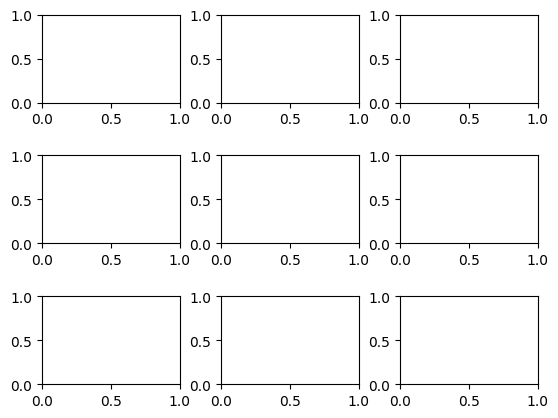

In [ ]:
class_names = ['car', 'no_object', 'dontcare', 'misc', 'cyclist', 'pedestrian', 'person', 'tram', 'truck', 'van']

fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, ax in enumerate(axes.flat):
    image = X_train[i].reshape(22, 18)  # 32 the dimensions as needed
    ax.imshow(image)

    xlabel = "class: {0}".format(class_names[y_train[i].argmax()])

    # Show the classes as the label on the x-axis
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0001, decay = 1e-6)

model = createModel(X_train.shape[1:])

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

In [ ]:
start_time = time.time()

model.fit(X_train, y_train, batch_size=32, epochs=10, shuffle=True, validation_data=(X_test, y_test))

elapsed_time = time.time() - start_time

print("Elapsed time: {0}".format(elapsed_time))

In [ ]:
# Try again with max pooling and moe deep learning hidden layers
def createModel2(input_shape):
    model = Sequential()
    model.add(Input(shape = input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0001, decay = 1e-6)

model = createModel2(X_train.shape[1:])

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

In [ ]:
start_time = time.time()

model.fit(X_train, y_train, batch_size=32, epochs=50, shuffle=True, validation_data=(X_test, y_test))

elapsed_time = time.time() - start_time

print("Elapsed time: {0}".format(elapsed_time))

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
for x in range(100):
    test_image = X_test[x,:]
    predicted_cat = model.predict(np.array([test_image])).argmax() # argmax returns the index of the max value
    label = y_test[x].argmax()
    if (predicted_cat != label):
        plt.title(f"Predicted: {class_names[predicted_cat]}, Label: {class_names[label]}")
        plt.imshow(test_image)
        plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('path_to_your_model.h5')

# Function to preprocess frames
def preprocess_frame(frame):
    # Resize, normalize, and expand dimensions as before
    # Adjust according to your model's requirements
    frame_resized = cv2.resize(frame, (64, 64))
    frame_normalized = frame_resized / 255.0
    frame_expanded = np.expand_dims(frame_normalized, axis=0)
    return frame_expanded

# Function to draw bounding boxes and labels
def draw_bounding_boxes(frame, predictions):
    height, width, _ = frame.shape
    for pred in predictions:
        # Assuming `pred` is a tuple of (class_label, confidence, (x_min, y_min, x_max, y_max))
        class_label, confidence, bbox = pred
        x_min, y_min, x_max, y_max = bbox

        # Convert normalized coordinates back to frame size
        x_min = int(x_min * width)
        y_min = int(y_min * height)
        x_max = int(x_max * width)
        y_max = int(y_max * height)

        # Draw rectangle
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        # Put the label near the rectangle
        cv2.putText(frame, f'{class_label}: {confidence:.2f}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Capture video from the first webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    preprocessed_frame = preprocess_frame(frame)
    
    # Predict using your model
    # Make sure to adjust the prediction line to how your model outputs predictions
    predictions = model.predict(preprocessed_frame)
    
    # Translate predictions to labels and bounding boxes here
    # This will depend on your model's output format
    # For demonstration, let's assume `predictions_to_boxes` will handle this
    # predictions = predictions_to_boxes(predictions)
    
    # Draw bounding boxes and labels on the frame
    draw_bounding_boxes(frame, predictions)

    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Jasleen Bedi

